In [24]:
import pandas as pd 
import os
import numpy as np
from skimage.io import imread
from sklearn.metrics import accuracy_score, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import MobileNetV2
import itertools
import pickle
import matplotlib.pyplot as plt 
import seaborn as sns
import random
import os

In [2]:
from google.colab import drive
drive.mount('/content/drive/')
os.chdir('/content/drive/MyDrive/')

Mounted at /content/drive/


In [3]:
def prepareDataNN(df):
    data = []
    labels = []
    df_filtered = pd.DataFrame(columns=["patch_filename", "plastic"])
    patches_path = '/content/drive/MyDrive/patches/'
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            data.append(im)
            labels.append(np.array(df.loc[i, 'plastic']))
            df_filtered = df_filtered.append(pd.Series(data={"patch_filename":df.loc[i, 'patch_filename'], "plastic":df.loc[i, 'plastic']}), ignore_index=True)
    return data, labels, df_filtered

In [4]:
def prepareData(df):
    data = []
    labels = []
    patches_path = '/content/drive/MyDrive/patches/'
    df_filtered = pd.DataFrame(columns=["patch_filename", "plastic"])
    for i in range(len(df)):
        patch_filename = os.path.join(patches_path, os.path.basename(df.loc[i, 'patch_filename']))
        im = imread(patch_filename)
        if im.shape == (256, 256, 3):
            feat, _ = np.histogram(im, bins = 100)
            data.append(feat)
            labels.append(df.loc[i, 'plastic'])
            df_filtered = df_filtered.append(pd.Series(data={"patch_filename":df.loc[i, 'patch_filename'], "plastic":df.loc[i, 'plastic']}), ignore_index=True)
    return data, labels, df_filtered

In [30]:
df = pd.read_csv('patch_info.csv')
_,_,df = prepareDataNN(df) # filter patches of size < 256 * 256

df_plastic = df[df.plastic==1].reset_index()
df_noplastic = df[df.plastic==0].reset_index()
df_unlab = df[df.plastic==-1].reset_index()

len(df_plastic), len(df_noplastic)

(359, 381)

In [8]:
df_labeled = pd.concat([df_plastic, df_noplastic], ignore_index=True)
partition = .85
test_set = df_labeled.copy()
print(len(test_set))
training_set = test_set.sample(frac=partition)
test_set = pd.merge(test_set, training_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge'], axis=1)#.reset_index()
print(len(test_set))
validation_set = test_set.sample(frac=.5)
test_set = pd.merge(test_set, validation_set, indicator=True, how='outer').query('_merge=="left_only"').drop(['_merge','index'], axis=1)#.reset_index()
print(len(test_set))

740
111
55


In [31]:
#training_set.to_csv('training_set.csv')
#test_set.to_csv('test_set.csv')
#validation_set.to_csv('validation_set.csv')
#df_unlab.to_csv('unlabeled.csv')

df_unlab = pd.read_csv('unlabeled.csv')
training_set = pd.read_csv('training_set.csv')
test_set = pd.read_csv('test_set.csv')
validation_set = pd.read_csv('validation_set.csv')

In [6]:
print(len(training_set[training_set['plastic']==0]), len(training_set[training_set['plastic']==1]) )
print(len(validation_set[validation_set['plastic']==0]), len(validation_set[validation_set['plastic']==1]) )
print(len(test_set[test_set['plastic']==0]), len(test_set[test_set['plastic']==1]) )

322 307
36 20
23 32


In [7]:
def get_preditictions(model, test_data):
    pred_prob = model.predict(np.array(test_data))
    pred_class = []
    for p in pred_prob:
        if p >= .5:
            pred_class.append(1)
        else:
            pred_class.append(0)
    print(classification_report(test_labels, pred_class))
    return (pred_prob, pred_class)

In [9]:
training_data, training_labels, _ = prepareDataNN(training_set)
validation_data, validation_labels, _ = prepareDataNN(validation_set)
test_data, test_labels, _ = prepareDataNN(test_set)

### Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import RandomizedSearchCV

n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [12]:
training_data_, training_labels_, _ = prepareData(training_set)
test_data_, test_labels_, _ = prepareData(test_set)

In [13]:
rfc = RandomForestClassifier(n_estimators=10, max_features=10)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rfc, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(training_data_, training_labels_)
best_rfc = rf_random.best_estimator_
best_rfc.fit(training_data_, training_labels_)
pred_probs_rf = best_rfc.predict_proba(test_data_)[:, 1]

print(classification_report(test_labels_,  best_rfc.predict(test_data_)))

              precision    recall  f1-score   support

         0.0       0.82      0.78      0.80        23
         1.0       0.85      0.88      0.86        32

    accuracy                           0.84        55
   macro avg       0.83      0.83      0.83        55
weighted avg       0.84      0.84      0.84        55



In [14]:
data_augmentation = keras.Sequential(
    [ layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.2),
      #layers.RandomTranslation(0.8, 0.5),
      #layers.RandomZoom(0.5),
      layers.RandomContrast(0.1),
    ]
)

### CNN training

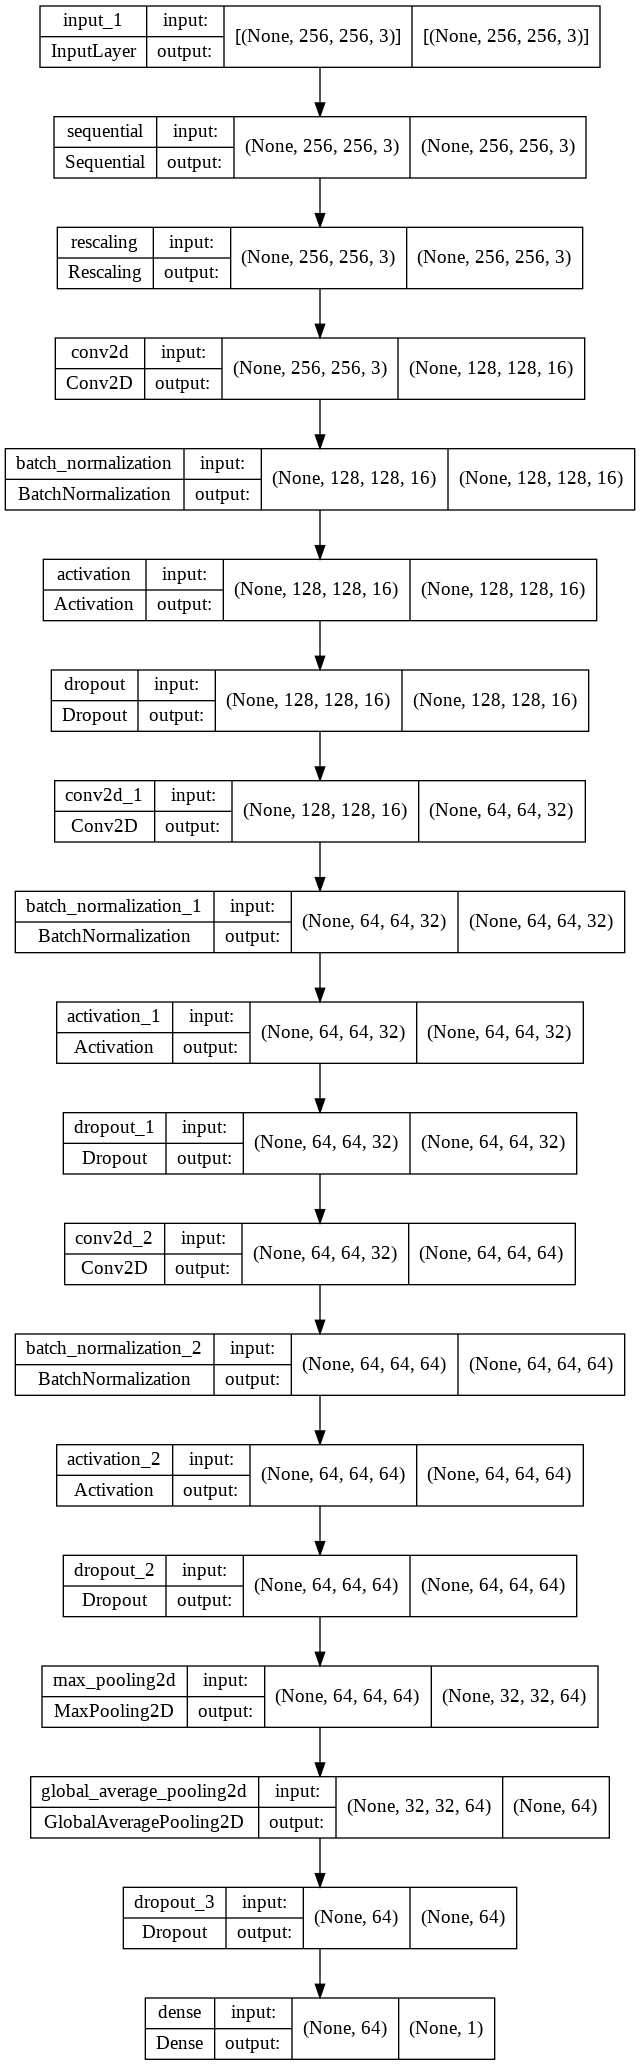

In [15]:
def make_model(input_shape):
    inputs = keras.Input(shape = input_shape)
    # Image augmentation block
    x = data_augmentation(inputs)

    # Architecture 
    x = layers.Rescaling(1.0 / 255)(x)

    #### added layers
    x = layers.Conv2D(16, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)
    ####

    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Dropout(0.25)(x)

    x = layers.MaxPooling2D(3, strides=2, padding="same")(x)
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.50)(x) # increased from .25

    outputs = layers.Dense(1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs)

image_size = (256, 256, 3) 
model = make_model(input_shape=image_size)
keras.utils.plot_model(model, to_file='code/figures/CNN.png', show_shapes=True)

In [34]:
epochs = 500
callbacks = [
    keras.callbacks.ModelCheckpoint("code/ckpts/cnn_{epoch}.h5", save_best_only=True),
]
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
hist_cnn = model.fit(
    x=np.array(training_data), y=np.array(training_labels) , epochs=epochs, callbacks=[callbacks, tensorboard], shuffle=True, batch_size=32, validation_data=(np.array(validation_data), np.array(validation_labels)))

# save history 
with open('code/ckpts/trainHistoryCNN', 'wb') as file_pi:
    pickle.dump(hist_cnn.history, file_pi)

Epoch 1/500
20/20 [==============================] - 2s 52ms/step - loss: 1.0672 - accuracy: 0.5437 - val_loss: 0.7076 - val_accuracy: 0.3571
Epoch 2/500
20/20 [==============================] - 1s 42ms/step - loss: 0.9376 - accuracy: 0.5803 - val_loss: 0.6939 - val_accuracy: 0.3571
Epoch 3/500
20/20 [==============================] - 1s 41ms/step - loss: 0.9285 - accuracy: 0.5835 - val_loss: 0.6881 - val_accuracy: 0.6250
Epoch 4/500
20/20 [==============================] - 1s 40ms/step - loss: 0.8551 - accuracy: 0.6121 - val_loss: 0.6875 - val_accuracy: 0.6429
Epoch 5/500
20/20 [==============================] - 1s 37ms/step - loss: 0.8514 - accuracy: 0.6328 - val_loss: 0.6878 - val_accuracy: 0.6429
Epoch 6/500
20/20 [==============================] - 1s 41ms/step - loss: 0.8862 - accuracy: 0.6264 - val_loss: 0.6865 - val_accuracy: 0.6429
Epoch 7/500
20/20 [==============================] - 1s 40ms/step - loss: 0.7799 - accuracy: 0.6582 - val_loss: 0.6826 - val_accuracy: 0.6429
Epoch 

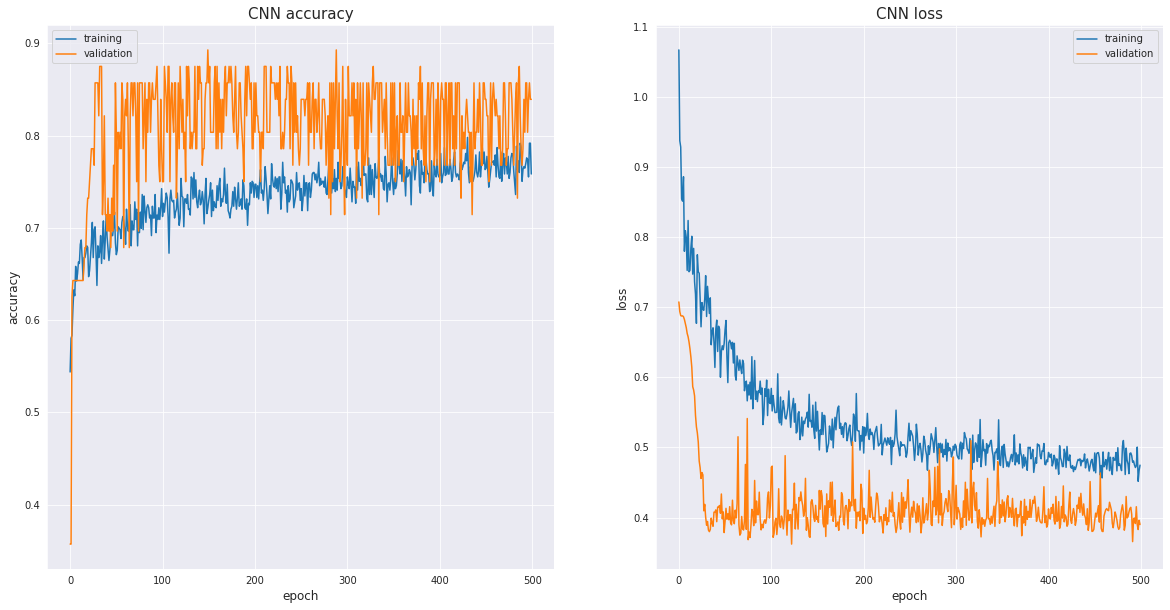

In [35]:
hist_cnn = pd.read_pickle('code/ckpts/trainHistoryCNN')

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.subplot(121)
plt.plot(hist_cnn['accuracy'])
plt.plot(hist_cnn['val_accuracy'])
plt.title('CNN accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper left')
plt.subplot(122)
plt.plot(hist_cnn['loss'])
plt.plot(hist_cnn['val_loss'])
plt.title('CNN loss', fontsize=15)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("code/figures/CNN_training_2.png")

In [17]:
model.load_weights("code/ckpts/cnn_193.h5")
model.compile(
    optimizer=keras.optimizers.Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
pred_probs_cnn, pred_class_cnn = get_preditictions(model, test_data)

              precision    recall  f1-score   support

         0.0       0.66      0.91      0.76        23
         1.0       0.91      0.66      0.76        32

    accuracy                           0.76        55
   macro avg       0.78      0.78      0.76        55
weighted avg       0.81      0.76      0.76        55



### CNN + Random Forest

In [22]:
final_layer = "global_average_pooling2d"
extractor = keras.Model(inputs=model.input,
                        outputs=model.get_layer(final_layer).output)
features = extractor(np.array(training_data))

rfcnn = RandomForestClassifier(n_estimators=10, max_features=10)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfcnn_random = RandomizedSearchCV(estimator = rfcnn, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1) #verbose=2, 
# Fit the random search model
rfcnn_random.fit(np.array(features), training_labels)

best_rfcnn = rfcnn_random.best_estimator_
best_rfcnn.fit(np.array(features), training_labels)

features_test = np.array(extractor(np.array(test_data)))
pred_probs_rfcnn = best_rfcnn.predict_proba(features_test)[:, 1]
accuracy_score(test_labels, best_rfcnn.predict(features_test))
print(classification_report(test_labels,  best_rfcnn.predict(features_test)))

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89        23
         1.0       0.91      0.94      0.92        32

    accuracy                           0.91        55
   macro avg       0.91      0.90      0.91        55
weighted avg       0.91      0.91      0.91        55



### MobNetV2 training

In [19]:
# preprocess data 
inputs = keras.Input(shape = (256, 256, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1.0 / 255)(x)

# load pre-trained model and weights without last layer
x = MobileNetV2(weights='imagenet', include_top=False, input_shape=(256, 256, 3))(x)

# add layers on top
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.25)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)

# final model to train
tf_model_mobnet = keras.Model(inputs, outputs)

for layer in tf_model_mobnet.layers:
    if layer.name == 'mobilenetv2_1.00_224':
        print(len(layer.layers))
        for l in layer.layers[-20:]:
            l.trainable = True

9420800/9406464 [==============================] - 0s 0us/step
154


In [53]:
epochs = 50
callbacks = [
    keras.callbacks.ModelCheckpoint("code/ckpts/mobnetv2_{epoch}.h5", save_best_only=True),
]
tensorboard = keras.callbacks.TensorBoard(log_dir='./logs',
                 histogram_freq=1, 
                 write_graph=True, 
                 write_images=False)

tf_model_mobnet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
hist_mobnet = tf_model_mobnet.fit(
    x=np.array(training_data), y=np.array(training_labels) , epochs=epochs, callbacks=[callbacks, tensorboard], shuffle=True, batch_size=32, validation_data=(np.array(validation_data), np.array(validation_labels))
)

# save history 
with open('code/ckpts/trainHistoryMobNetV2', 'wb') as file_pi:
    pickle.dump(hist_mobnet.history, file_pi)

Epoch 1/50
20/20 [==============================] - 15s 470ms/step - loss: 0.6178 - accuracy: 0.7377 - val_loss: 3.5950 - val_accuracy: 0.6607
Epoch 2/50
20/20 [==============================] - 7s 363ms/step - loss: 0.4416 - accuracy: 0.8394 - val_loss: 3.0385 - val_accuracy: 0.6429
Epoch 3/50
20/20 [==============================] - 7s 359ms/step - loss: 0.3478 - accuracy: 0.8521 - val_loss: 0.7588 - val_accuracy: 0.6429
Epoch 4/50
20/20 [==============================] - 6s 323ms/step - loss: 0.3257 - accuracy: 0.8680 - val_loss: 3.1683 - val_accuracy: 0.6429
Epoch 5/50
20/20 [==============================] - 6s 324ms/step - loss: 0.2882 - accuracy: 0.8839 - val_loss: 1.4457 - val_accuracy: 0.3571
Epoch 6/50
20/20 [==============================] - 6s 327ms/step - loss: 0.3397 - accuracy: 0.8490 - val_loss: 2.1835 - val_accuracy: 0.3571
Epoch 7/50
20/20 [==============================] - 7s 331ms/step - loss: 0.2495 - accuracy: 0.8983 - val_loss: 2.6778 - val_accuracy: 0.6429
Epoch

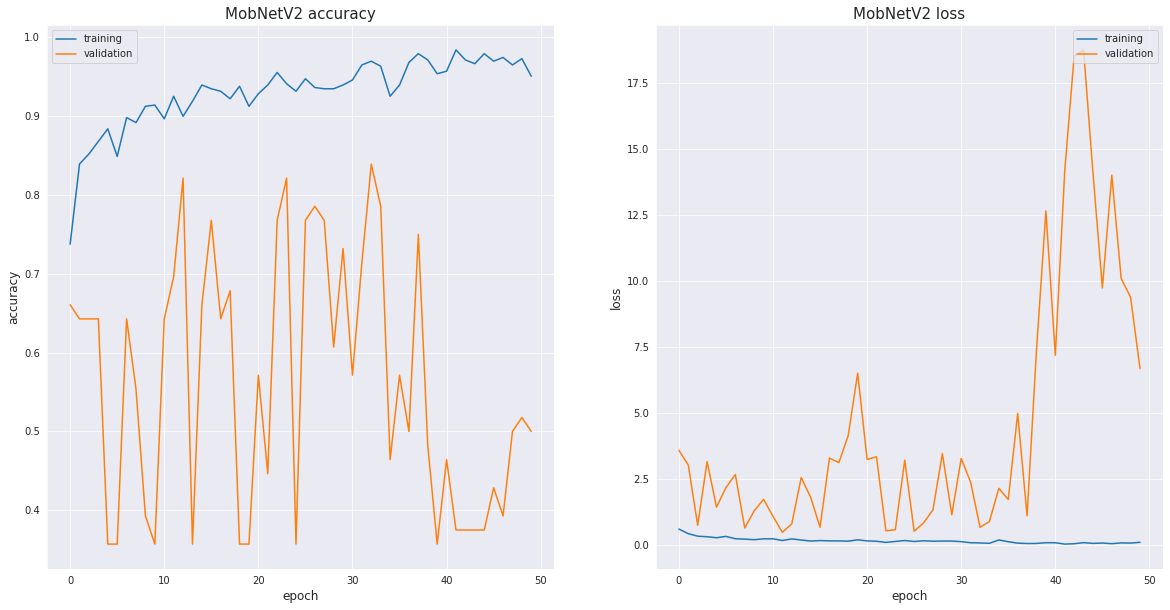

In [55]:
hist_mobnet = pd.read_pickle('code/ckpts/trainHistoryMobNetV2')

plt.figure(figsize=(20,10))
sns.set_style("darkgrid")
plt.subplot(121)
plt.plot(hist_mobnet['accuracy'])
plt.plot(hist_mobnet['val_accuracy'])
plt.title('MobNetV2 accuracy', fontsize=15)
plt.ylabel('accuracy', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper left')
plt.subplot(122)
plt.plot(hist_mobnet['loss'])
plt.plot(hist_mobnet['val_loss'])
plt.title('MobNetV2 loss', fontsize=15)
plt.ylabel('loss', fontsize=12)
plt.xlabel('epoch', fontsize=12)
plt.legend(['training', 'validation'], loc='upper right')
plt.savefig("code/figures/MobNetV2_training.png")

In [20]:
tf_model_mobnet.load_weights("code/ckpts/mobnetv2_12.h5")
tf_model_mobnet.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
)
pred_probs_mobnet, pred_class_mobnet = get_preditictions(tf_model_mobnet, test_data)

              precision    recall  f1-score   support

         0.0       0.80      0.70      0.74        23
         1.0       0.80      0.88      0.84        32

    accuracy                           0.80        55
   macro avg       0.80      0.79      0.79        55
weighted avg       0.80      0.80      0.80        55



### MobNetV2 + Random Forest

In [26]:
# extract features from last layer
final_layer = "global_average_pooling2d_1"
extractor_mobnet = keras.Model(inputs=tf_model_mobnet.input,
                        outputs=tf_model_mobnet.get_layer(final_layer).output)
features_mobnet = []
step = 300
for i in range(0, len(training_data), step):
    if i + step >= len(training_data):
        end = len(training_data)
    else: 
        end = i + step
    features_mobnet.append(np.array(extractor_mobnet(np.array(training_data[i:end]))))
features_mobnet = np.array(list(itertools.chain(*features_mobnet)))
features_mobnet_test = np.array(extractor_mobnet(np.array(test_data)))

# train random forest with mobnetfeatures 
rfmobnet = RandomForestClassifier(n_estimators=10, max_features=10) #

# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rfmobnet_random = RandomizedSearchCV(estimator = rfmobnet, param_distributions = random_grid, n_iter = 100, cv = 3, random_state=42, n_jobs = -1) #verbose=2, 
# Fit the random search model
rfmobnet_random.fit(np.array(features_mobnet), training_labels)

best_rfmobnet = rfmobnet_random.best_estimator_
best_rfmobnet.fit(np.array(features_mobnet), training_labels)

pred_probs_rfmobnet = best_rfmobnet.predict_proba(features_mobnet_test)[:, 1]
accuracy_score(test_labels, best_rfmobnet.predict(features_mobnet_test))
print(classification_report(test_labels,  best_rfmobnet.predict(features_mobnet_test)))

              precision    recall  f1-score   support

         0.0       0.79      0.96      0.86        23
         1.0       0.96      0.81      0.88        32

    accuracy                           0.87        55
   macro avg       0.87      0.88      0.87        55
weighted avg       0.89      0.87      0.87        55



### Self-Supervised 


In [32]:
# unlabeled
X, Y, _ = prepareDataNN(df_unlab)

# merge labeled and unlabeled datasets
training_data_ss = training_data + X 
training_labels_ss = training_labels + Y

### CNN + Random Forest

In [33]:
from sklearn.semi_supervised import SelfTrainingClassifier
import itertools

final_layer = "global_average_pooling2d"
extractor = keras.Model(inputs=model.input,
                        outputs=model.get_layer(final_layer).output)
features_cnn = []
step = 300
for i in range(0, len(training_data_ss), step):
    if i + step >= len(training_data_ss):
        end = len(training_data_ss)
    else: 
        end = i + step
    features_cnn.append(np.array(extractor(np.array(training_data_ss[i:end]))))
features_cnn = np.array(list(itertools.chain(*features_cnn)))

In [34]:
features_test_cnn = np.array(extractor(np.array(test_data)))
self_training_model_cnn = SelfTrainingClassifier(base_estimator=best_rfcnn)
self_training_model_cnn.fit(features_cnn, training_labels_ss)
print(classification_report(test_labels,  self_training_model_cnn.predict(features_test_cnn)))

              precision    recall  f1-score   support

         0.0       0.91      0.87      0.89        23
         1.0       0.91      0.94      0.92        32

    accuracy                           0.91        55
   macro avg       0.91      0.90      0.91        55
weighted avg       0.91      0.91      0.91        55



In [35]:
pred_probs_rfcnn_ss = self_training_model_cnn.predict_proba(features_test)[:, 1]

### MobileNetv2 + Random Forest

In [36]:
from sklearn.semi_supervised import SelfTrainingClassifier
import itertools

final_layer = "global_average_pooling2d_1"
extractor_mobnet = keras.Model(inputs=tf_model_mobnet.input,
                        outputs=tf_model_mobnet.get_layer(final_layer).output)
features_mobnet = []
step = 300
for i in range(0, len(training_data_ss), step):
    if i + step >= len(training_data_ss):
        end = len(training_data_ss)
    else: 
        end = i + step
    features_mobnet.append(np.array(extractor_mobnet(np.array(training_data_ss[i:end]))))
features_mobnet = np.array(list(itertools.chain(*features_mobnet)))

In [37]:
features_test_mobnet = np.array(extractor_mobnet(np.array(test_data)))
self_training_model = SelfTrainingClassifier(base_estimator=best_rfmobnet)
self_training_model.fit(features_mobnet, training_labels_ss)
print(classification_report(test_labels,  self_training_model.predict(features_test_mobnet)))

              precision    recall  f1-score   support

         0.0       0.71      0.96      0.81        23
         1.0       0.96      0.72      0.82        32

    accuracy                           0.82        55
   macro avg       0.83      0.84      0.82        55
weighted avg       0.85      0.82      0.82        55



In [38]:
pred_probs_rfmobnet_ss = self_training_model.predict_proba(features_test)[:, 1]

## Classifier Precision-Recall curve comparisons 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


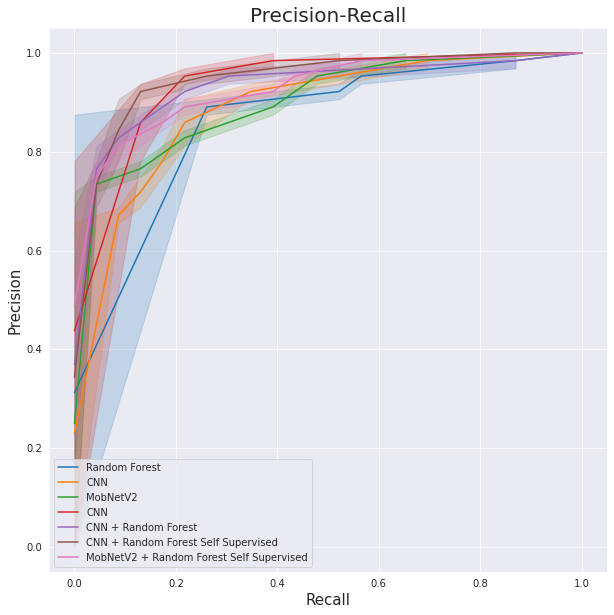

In [41]:
import matplotlib.pyplot as plt 
from sklearn.metrics import roc_curve, plot_roc_curve

import seaborn as sns 

plt.figure(figsize=(10,10))
plt.title("Precision-Recall", fontsize=20)

sns.set_style("darkgrid")
# RF
fpr, tpr, thresholds = roc_curve(test_labels_, pred_probs_rf)
sns.lineplot(x=fpr, y=tpr, label="Random Forest")

sns.set_style("darkgrid")
# CNN
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_cnn)
sns.lineplot(x=fpr, y=tpr, label="CNN")

sns.set_style("darkgrid")
# MobNetV2
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_mobnet)
sns.lineplot(x=fpr, y=tpr, label="MobNetV2")

sns.set_style("darkgrid")
# CNN + Random Forest
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_rfcnn)
sns.lineplot(x=fpr, y=tpr, label="CNN")

sns.set_style("darkgrid")
# MobNetV2 + Random Forest
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_rfmobnet)
sns.lineplot(x=fpr, y=tpr, label="CNN + Random Forest")

sns.set_style("darkgrid")
# CNN + Random Forest Self_Supervised
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_rfcnn_ss)
sns.lineplot(fpr, tpr, label="CNN + Random Forest Self Supervised")

sns.set_style("darkgrid")
# MobNetV2 + Random Forest Self_Supervised
fpr, tpr, thresholds = roc_curve(test_labels, pred_probs_rfmobnet_ss)
sns.lineplot(x=fpr, y=tpr, label="MobNetV2 + Random Forest Self Supervised")
plt.legend()
sns.set_style("darkgrid")

plt.ylabel("Precision", fontsize=15)
plt.xlabel("Recall", fontsize=15)
plt.savefig("code/figures/ROC_RF_CNN_MobNetV2_ss.png")

In [42]:
test = pd.read_csv('test_set.csv', usecols = ['patch_filename','plastic'])

In [44]:
pred_class_rfcnn = best_rfcnn.predict(features_test_cnn)
test_set['predicted'] = pred_class_rfcnn

In [48]:
pred_class_mobnet = best_rfmobnet.predict(features_mobnet_test)
test_set['predicted'] = pred_class_mobnet

In [49]:
correct_class = pd.DataFrame(columns=['patch_filename', 'plastic', 'predicted'])
misclassified = pd.DataFrame(columns=['patch_filename', 'plastic', 'predicted'])
for i in range(len(test_set)):
  if test_set.loc[i, 'predicted'] == test_set.loc[i, 'plastic']:
    correct_class = correct_class.append(test_set.loc[i,['patch_filename', 'plastic', 'predicted']])
  else:
    misclassified = misclassified.append(test_set.loc[i,['patch_filename', 'plastic', 'predicted']])


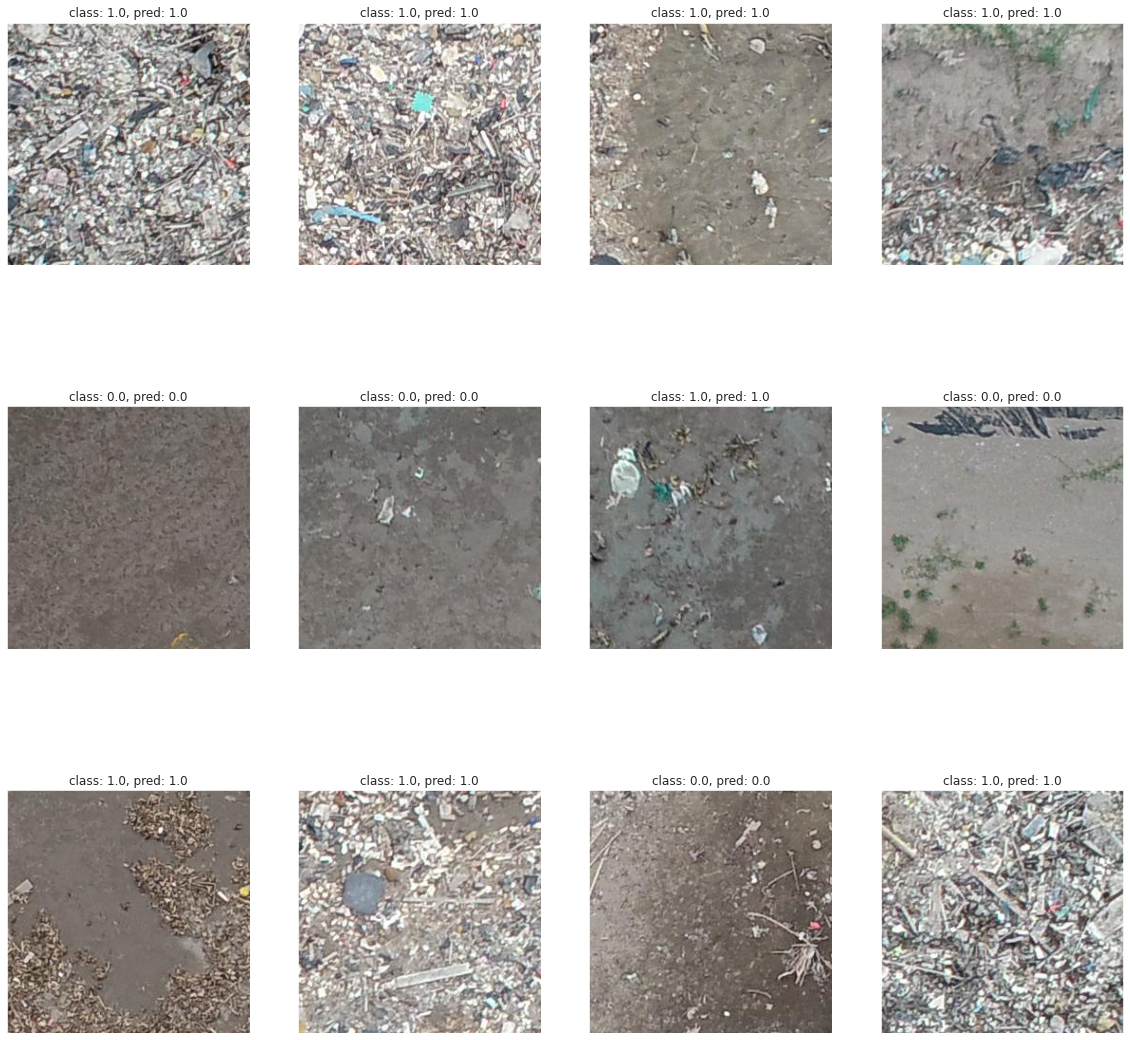

In [52]:
import random
plt.figure(figsize=(20,20))
correct_class = correct_class.reset_index(drop=True)
ind = random.sample(range(0, len(correct_class)), 12)
patches_path = '/content/drive/MyDrive/patches/'
for i in range(12):
  plt.subplot(3, 4, i+1)
  patch_filename = os.path.join(patches_path, os.path.basename(correct_class.loc[ind[i], 'patch_filename']))
  plt.imshow(imread(patch_filename))
  plt.title("class: {}, pred: {}".format(correct_class.loc[ind[i], 'plastic'], correct_class.loc[ind[i], 'predicted']))
  plt.xticks([])
  plt.yticks([])
  plt.savefig('code/figures/correctly_classified_MOBNETRF.png')

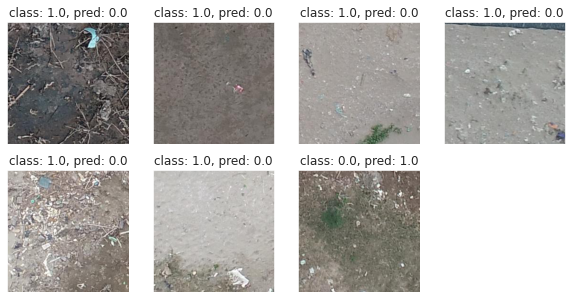

In [55]:
plt.figure(figsize=(10,5))
misclassified = misclassified.reset_index(drop=True)
#ind = random.sample(range(0, len(misclassified)), 10)
patches_path = '/content/drive/MyDrive/patches/'
for i in range(7):
  plt.subplot(2,4, i+1)
  patch_filename = os.path.join(patches_path, os.path.basename(misclassified.loc[i, 'patch_filename']))
  plt.imshow(imread(patch_filename))
  plt.title("class: {}, pred: {}".format(misclassified.loc[i, 'plastic'], misclassified.loc[i, 'predicted']))
  plt.xticks([])
  plt.yticks([])
  plt.savefig('code/figures/misclassified_MOBNETRF.png')

In [157]:
misclassified

,patch_filename,plastic,predicted
0,/home/giorgia/Desktop/MAI/Thesis/images/select...,1.0,0.0
1,/home/giorgia/Desktop/MAI/Thesis/images/select...,1.0,0.0
2,/home/giorgia/Desktop/MAI/Thesis/images/select...,0.0,1.0
3,/home/giorgia/Desktop/MAI/Thesis/images/select...,0.0,1.0
4,/home/giorgia/Desktop/MAI/Thesis/images/select...,0.0,1.0
